In [50]:
import numpy as np 
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
def preprocess_data(data, labels):
    data = data / 255.0

    hour_labels = labels[:, 0] - 1
    minute_labels = labels[:, 1]

    hour_labels_one_hot = tf.keras.utils.to_categorical(hour_labels, num_classes=12)

    minute_labels = minute_labels.reshape(-1, 1)

    if len(data.shape) == 3:
        data = data.reshape(-1, data.shape[1], data.shape[2], 1)
    
    data_train, data_temp, hour_train, hour_temp, minute_train, minute_temp = train_test_split(
        data, hour_labels_one_hot, minute_labels, test_size=0.2, random_state=42, shuffle=True
    )
    
    data_val, data_test, hour_val, hour_test, minute_val, minute_test = train_test_split(
        data_temp, hour_temp, minute_temp, test_size=0.5, random_state=42
    )
    
    labels_train = {'hour_output': hour_train, 'minute_output': minute_train}
    labels_val = {'hour_output': hour_val, 'minute_output': minute_val}
    labels_test = {'hour_output': hour_test, 'minute_output': minute_test}
    
    return data_train, labels_train, data_test, labels_test, data_val, labels_val


def common_sense_metric_minute(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 60.0 - linear_diff)

    return tf.reduce_mean(circular_diff)


def common_sense_loss_minute(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 60.0 - linear_diff)

    return tf.reduce_mean(tf.square(circular_diff))


def plot_hour_accuracy(history):
    accuracy = history.history['hour_output_accuracy']
    val_accuracy = history.history['val_hour_output_accuracy']
    
    plt.figure(figsize=(8, 6))
    plt.plot(accuracy, label='Training accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.title('Training and validation accuracy on hour prediction')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    

def plot_minute_mae(history):
    mae = history.history.get('minute_output_common_sense_metric_minute') 
    val_mae = history.history.get('val_minute_output_common_sense_metric_minute') 
    
    if mae is None or val_mae is None:
        raise ValueError("MAE metrics not found in history object. Available keys are: {}".format(history.history.keys()))
    
    
    plt.figure(figsize=(8, 6))
    plt.plot(mae, label='Training common sense error')
    plt.plot(val_mae, label='Validation common sense error')
    plt.title('Training and validation common sense error on minute prediction')
    plt.xlabel('Epochs')
    plt.ylabel('Common sense error')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_distribution(y_true, predictions, num_bins=30):
    hour_pred_probs = predictions['hour_output']
    hour_pred_classes = np.argmax(hour_pred_probs, axis=1)  # Class labels (0-11)
    hour_pred_classes += 1

    minute_pred = predictions['minute_output'].flatten()

    hour_true_one_hot = y_true['hour_output']
    hour_true_classes = np.argmax(hour_true_one_hot, axis=1)

    minute_true = y_true['minute_output'].flatten()

    time_pred = hour_pred_classes * 60 + minute_pred
    time_true = hour_true_classes * 60 + minute_true

    error = tf.abs(time_pred - time_true)
    absolute_error = tf.minimum(error, 720 - error)

    plt.figure(figsize=(10, 6))
    plt.hist(absolute_error, bins=num_bins, color='skyblue', edgecolor='black')
    plt.title('Distribution of common sense errors')
    plt.xlabel('Common sense error (minutes)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(time_true, time_pred)
    rmse = np.sqrt(mean_squared_error(time_true, time_pred))

    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 36, 36,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 17,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 7, 7, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    802,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour_output (Dense) │ (None, 12)        │      1,548 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ minute_output       │ (None, 1)         │         65 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 905,485 (3.45 MB)

 Trainable params: 905,485 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - hour_output_accuracy: 0.0794 - hour_output_loss: 30.0647 - loss: 33.3223 - minute_output_common_sense_metric_minute: 15.0287 - minute_output_loss: 3.0100 - val_hour_output_accuracy: 0.0889 - val_hour_output_loss: 29.8196 - val_loss: 32.9792 - val_minute_output_common_sense_metric_minute: 14.8234 - val_minute_output_loss: 2.9493
Epoch 2/400
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - hour_output_accuracy: 0.0817 - hour_output_loss: 29.8286 - loss: 33.0495 - minute_output_common_sense_metric_minute: 14.9346 - minute_output_loss: 2.9809 - val_hour_output_accuracy: 0.0817 - val_hour_output_loss: 29.8183 - val_loss: 32.9694 - val_minute_output_common_sense_metric_minute: 14.8232 - val_minute_output_loss: 2.9488
Epoch 3/400
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - hour_output_accuracy: 0.0848 - hour_output_loss: 29.8242 - loss: 33.0800 - minute_output_common_sense_metric_minute: 15.0925 - minute_output_loss: 3.0245 - val_hour_output_acc

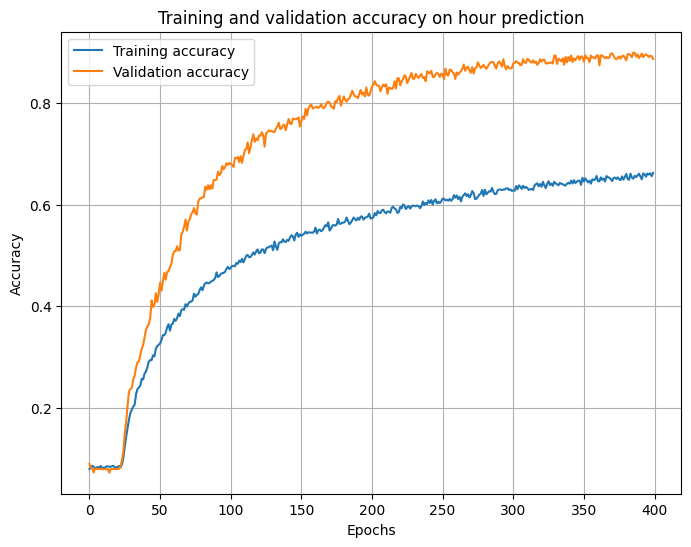

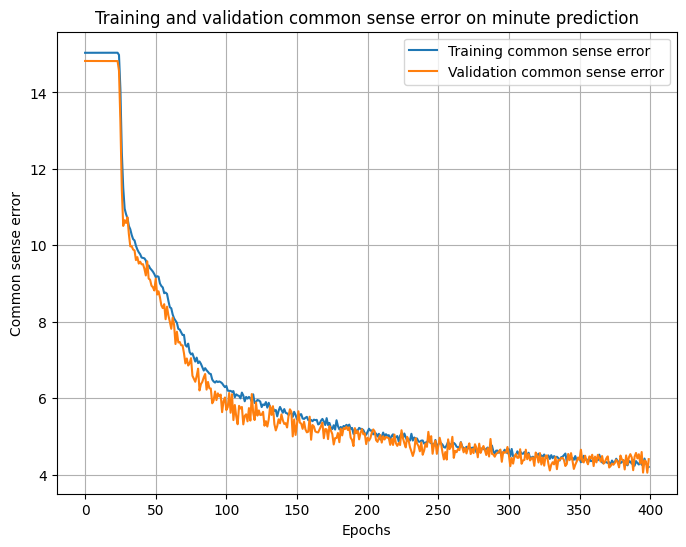

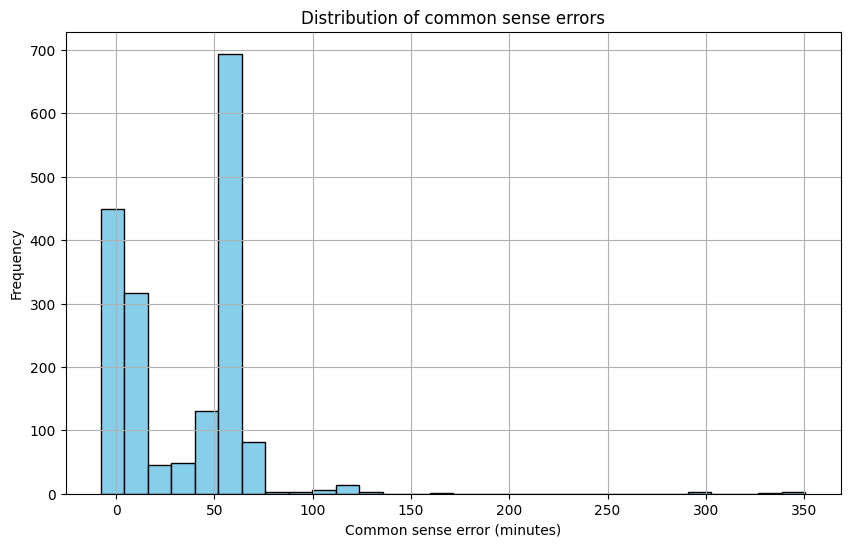

Mean Absolute Error (MAE): 39.59 minutes


In [ ]:
def create_multi_head_model(image_length, data, labels):
    tf.keras.backend.clear_session()
    gc.collect()
    data_train, labels_train, data_test, labels_test, data_val, labels_val = preprocess_data(data, labels)

    # Input layer
    input_layer = Input(shape=(image_length, image_length, 1))

    # Shared base: Convolutional layers
    # Layer 0
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    # Layer 1
    x = Conv2D(64, (3, 3), activation='relu')(x)    
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    # Layer 2
    x = Conv2D(128, (3, 3), activation='relu')(x)    
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    # Head 1: Predict hour components (classification)
    x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
    head1 = Dropout(0.4)(x)
    head1_output = Dense(12, activation='softmax', name='hour_output')(head1)

    # Head 2: Predict minute components (regression)
    head2 = Dense(64, activation='relu')(x)
    head2_output = Dense(1, name='minute_output')(head2)

    model = Model(inputs=input_layer, outputs={'hour_output': head1_output, 'minute_output': head2_output})

    optimizer = Adam(learning_rate=1e-4)

    model.summary()

    model.compile(
        optimizer=optimizer,
        loss={'hour_output': 'categorical_crossentropy', 'minute_output': common_sense_loss_minute},
        loss_weights={'hour_output': 12.0, 'minute_output': 0.01},
        metrics={'hour_output': 'accuracy', 'minute_output': common_sense_metric_minute}
    )

    history = model.fit(
        data_train,
        {'hour_output': labels_train['hour_output'], 'minute_output': labels_train['minute_output']},
        epochs=400,
        batch_size=32,
        validation_data=(data_val, {'hour_output': labels_val['hour_output'], 'minute_output': labels_val['minute_output']})
    )

    results = model.evaluate(data_test, labels_test, return_dict=True)

    return model, history, results, data_test, labels_test


def run(image_size=75):
    if image_size == 75: 
        data = np.load('../clocks_small/images.npy')
        labels = np.load('../clocks_small/labels.npy')
    elif image_size == 150:
        data = np.load('../clocks_large/images.npy')
        labels = np.load('../clocks_large/labels.npy')

    model, history, results, data_test, labels_test = create_multi_head_model(image_size, data, labels)

    # Evaluation results
    total_loss = results['loss']
    hour_loss = results['hour_output_loss']
    minute_loss = results['minute_output_loss']
    hour_accuracy = results['hour_output_accuracy']
    minute_mae = results['minute_output_common_sense_metric_minute']

    print(f"Test Loss: {total_loss}")
    print(f"Hour Loss: {hour_loss}, Hour Accuracy: {hour_accuracy}")
    print(f"Minute Loss: {minute_loss}, Minute MAE: {minute_mae}")

    predictions = model.predict(data_test)
    plot_hour_accuracy(history)    
    plot_minute_mae(history)
    plot_error_distribution(labels_test, predictions)


run(75)